# CV, min, max and WG predictions from profiling connections

## Import

In [32]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
from LabData.DataLoaders.SubjectLoader import SubjectLoader
from LabData.DataLoaders.BodyMeasuresLoader import BodyMeasuresLoader
from LabData.DataLoaders.BloodTestsLoader import BloodTestsLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import graphviz


In [179]:
import plotly.express as px
import shap

## CGM profiling connections

### PNP3

In [34]:
cgmdf = cgml.get_data(study_ids=3).df
cgmdf = cgml._remove_first_day_of_connections(cgmdf)

In [118]:
prof_cgm_pnp3 = pd.read_csv('/home/elming/Cache/profling_cgm_pnp3.csv')

In [119]:
prof_cgm_pnp3.shape

(374836, 5)

In [120]:
# for i in prof_cgm_pnp3.set_index(['UserID', 'ConnectionID']).index.unique():
#     print(i)

In [121]:
prof_cid = prof_cgm_pnp3['ConnectionID'].unique()

prof_cid = [str(i) for i in prof_cid]

In [122]:
profling_cgm = cgmdf.reset_index()[cgmdf.reset_index()['ConnectionID'].isin(prof_cid)]

In [123]:
profling_cgm = profling_cgm.set_index(['Date'])

In [124]:
profling_cgm = profling_cgm.reset_index()
profling_cgm['Day'] = profling_cgm['Date'].dt.date


In [125]:
prof_index_pnp3 = profling_cgm.set_index(['RegistrationCode', 'Day']).index.unique()

In [126]:
profling_cgm.head()

,Date,RegistrationCode,ConnectionID,GlucoseValue,PPGR,Day
0,2017-11-07 14:28:00,111527,1926,108.0,16.75,2017-11-07
1,2017-11-07 14:43:00,111527,1926,118.0,1.25,2017-11-07
2,2017-11-07 14:58:00,111527,1926,119.0,2.75,2017-11-07
3,2017-11-07 15:13:00,111527,1926,119.0,5.50,2017-11-07
4,2017-11-07 15:28:00,111527,1926,121.0,3.25,2017-11-07


In [127]:
cgm_pnp3 = profling_cgm

### PNP1

Below _f stands for filtered

In [45]:
cgm_pnp1 = cgml.get_data(study_ids=1).df

In [46]:
cgm_pnp1 = cgml._remove_first_day_of_connections(cgm_pnp1)

In [54]:
cgm_pnp1.head()

GlucoseValue  PPGR
RegistrationCode ConnectionID Date                                   
-1               1            2013-01-22 14:25:44          98.0   0.0
                              2013-01-22 14:30:44          99.0   0.0
                              2013-01-22 14:35:44          99.0   0.0
                              2013-01-22 14:40:44          99.0   0.0
                              2013-01-22 14:45:44          98.0   0.0

I need to filter for people with A1C >= 5.7. So, I need to load the blood tests

In [48]:
btl = BloodTestsLoader()
blood_tests_pnp1 = btl.get_data(study_ids=1).df

In [49]:
# for col in blood_tests.columns:
#     print(col)

In [50]:
blood_tests_pnp1_f = blood_tests_pnp1[blood_tests_pnp1['bt__hba1c'] >= 5.7]

In [51]:
prediabetic_pnp1_index = blood_tests_pnp1[blood_tests_pnp1['bt__hba1c'] >= 5.7].index.get_level_values('RegistrationCode')

In [52]:
cgm_pnp1_f = cgm_pnp1[cgm_pnp1.index.get_level_values('RegistrationCode').isin(prediabetic_pnp1_index)]

In [23]:
profling_cgm.head()

,RegistrationCode,ConnectionID,GlucoseValue,PPGR
Date,,,,
2017-11-07 14:28:00,111527,1926,108.0,16.75
2017-11-07 14:43:00,111527,1926,118.0,1.25
2017-11-07 14:58:00,111527,1926,119.0,2.75
2017-11-07 15:13:00,111527,1926,119.0,5.50
2017-11-07 15:28:00,111527,1926,121.0,3.25


In [55]:
cgm_pnp1_f = cgm_pnp1_f.reset_index()
cgm_pnp1_f['Day'] = cgm_pnp1_f['Date'].dt.date

prof_index_pnp1 = cgm_pnp1_f.set_index(['RegistrationCode', 'Day']).index.unique()

## Wake up glucose on profiling

### PNP3

In [57]:
def calculate_wakeup_glucose(cgmdf, time_between = [5,7], study_ids=3):    

    """Calculates wakeup glucose in the interval given in time_between 
    depending on the breakfast time"""
    

    #  Get the log df 
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, ['energy_kcal'])
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    
    # Filter out beverages with 0 kcal
    logdf = logdf[logdf['energy_kcal'] != 0]
    
    # Filter out days with first meals earlier than 6 am. Sorting is required because otherwise early testmeals appear at the end of the daily meals list
    firstmeals = pd.DataFrame(logdf.sort_values(['RegistrationCode', 'Day', 'Date']).
                              groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
    firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]
    
    # Dtype handling. After groupby 'Day' is an object, but I need it to be datetime
    firstmeals = firstmeals.reset_index('Day')
    firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])
    firstmeals = firstmeals.set_index('Day', append=True)
    cgmdf['Day'] = cgmdf.index.date
    cgmdf['hour'] = cgmdf.index.hour
    cgmdf = cgmdf.set_index(['RegistrationCode', 'Day'])
    
    # Get cgm and firstmeals ts in one df
    cgm_fm = pd.merge(cgmdf, firstmeals, on=['RegistrationCode', 'Day'])
    
    # Leave cgm timestamps between 5 and 7 only
    cgm_fm = cgm_fm[(cgm_fm['hour'] >= time_between[0]) & (cgm_fm['hour'] < time_between[1])]
    
    # If breakfast was between 6 and 7 then wakeup glucose is a mean value between 5 and 6, otherwise between 6 and 7
    cgm_fm = cgm_fm[((cgm_fm['hour'] == time_between[0]) & (cgm_fm['breakfast_ts'].dt.hour == time_between[0] + 1)) | 
                    ((cgm_fm['hour'] == time_between[0] + 1) & (cgm_fm['breakfast_ts'].dt.hour >= time_between[1]))]
    wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseValue'].mean().rename(
                                'wakeup_glucose'))
    wakeup_glucose = wakeup_glucose.reset_index('hour').drop(columns='hour')
    
    return wakeup_glucose

In [73]:
wg_pnp3 = calculate_wakeup_glucose(cgm_pnp3.set_index(['Date']), time_between = [5,7], study_ids=3)

In [74]:
wg_pnp3.shape

(2211, 1)

### PNP1 

In [62]:
wg_pnp1 = calculate_wakeup_glucose(cgm_pnp1_f.set_index(['Date']), time_between = [5,7], study_ids=1)

In [63]:
wg_pnp1.shape

(1101, 1)

In [64]:
wg_both = pd.concat([wg_pnp3, wg_pnp1])

## Hourly Food log on profiling

### PNP3

In [65]:
def make_hourly_log(nutrient_list, study_ids, prof_index, min_cal_per_day=1000):
    
    """From the raw logdf I get a DataFrame with RC and Date as index and nutritional data aggregated on hourly bases.
    Resulting DataFrame has a column multiindex structure (hour_of_the_day, nutrient)
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    log = log.reset_index()
    log['Day'] = log['Date'].dt.date
    log = log.set_index(['RegistrationCode', 'Day'])
    log = log.loc[prof_index].reset_index().drop(columns='Day').set_index(['RegistrationCode', 'Date', 'food_id'])
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    # Add 1 day to the day column for later correct merge with the features to predict (CV and WG)
    logdf['Day'] = logdf['Day'] + datetime.timedelta(days=1)
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    logdf['hour'] = logdf['Date'].dt.hour
    # Adding Date to index for correct dropping of the 0 kcal rows
    logdf = logdf.set_index('Date', append=True)
    # Drop rows rows with 0 energy (should be water or tea)
    logdf = logdf.drop(logdf[logdf['energy_kcal'] == 0].index)
    logdf = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'hour']).sum()
    # Add additional features
#     logdf['carbs/lipids'] = logdf['carbohydrate_g'] / logdf['totallipid_g']
    logdf['caloric%carbs'] = logdf['carbohydrate_g'] * carbs_cal_per_gram / logdf['energy_kcal']
    logdf['caloric%fat'] = logdf['totallipid_g'] * fat_cal_per_gram / logdf['energy_kcal']

    # Arrange a data frame in a column multiindex format
    hourly_log = logdf.drop(columns='score').stack().unstack(level=2).unstack(level=-1)
    hourly_log = hourly_log.replace(np.NaN, 0)
    hourly_log.columns.names = (None, None)    
    
    return hourly_log

In [66]:
nutrient_list = ['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g']

In [75]:
hourly_log_pnp3 = make_hourly_log(nutrient_list, study_ids=3, prof_index=prof_index_pnp3)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [76]:
hourly_log_pnp3.shape

(2597, 264)

In [77]:
hourly_log_pnp3.head()

0                                    \
                            caffeine_mg sugarstotal_g weight energy_kcal   
RegistrationCode Day                                                       
111527           2017-11-08         0.0           0.0    0.0         0.0   
                 2017-11-09         0.0           0.0    0.0         0.0   
                 2017-11-10         0.0           0.0    0.0         0.0   
                 2017-11-11         0.0           0.0    0.0         0.0   
                 2017-11-12         0.0           0.0    0.0         0.0   

                                                              \
                            protein_g sodium_mg totallipid_g   
RegistrationCode Day                                           
111527           2017-11-08       0.0       0.0          0.0   
                 2017-11-09       0.0       0.0          0.0   
                 2017-11-10       0.0       0.0          0.0   
                 2017-11-11       0.0       0.0          0.0   
                 2017-11-12       0.0       0.0          0.0   

                                                                              \
                            totaldietaryfiber_g carbohydrate_g caloric%carbs   
RegistrationCode Day                                                           
111527           2017-11-08                 0.0            0.0           0.0   
                 2017-11-09                 0.0            0.0           0.0   
                 2017-11-10                 0.0            0.0           0.0   
                 2017-11-11                 0.0            0.0           0.0   
                 2017-11-12                 0.0            0.0           0.0   

                             ...            23                               \
                             ... sugarstotal_g weight energy_kcal protein_g   
RegistrationCode Day         ...                                              
111527           2017-11-08  ...           0.0    0.0         0.0       0.0   
                 2017-11-09  ...           0.0    0.0         0.0       0.0   
                 2017-11-10  ...           0.0    0.0         0.0       0.0   
                 2017-11-11  ...           0.0    0.0         0.0       0.0   
                 2017-11-12  ...           0.0    0.0         0.0       0.0   

                                                                        \
                            sodium_mg totallipid_g totaldietaryfiber_g   
RegistrationCode Day                                                     
111527           2017-11-08       0.0          0.0                 0.0   
                 2017-11-09       0.0          0.0                 0.0   
                 2017-11-10       0.0          0.0                 0.0   
                 2017-11-11       0.0          0.0                 0.0   
                 2017-11-12       0.0          0.0                 0.0   

                                                                      
                            carbohydrate_g caloric%carbs caloric%fat  
RegistrationCode Day                                                  
111527           2017-11-08            0.0           0.0         0.0  
                 2017-11-09            0.0           0.0         0.0  
                 2017-11-10            0.0           0.0         0.0  
                 2017-11-11            0.0           0.0         0.0  
                 2017-11-12            0.0           0.0         0.0  

[5 rows x 264 columns]

### PNP1

In [78]:
hourly_log_pnp1 = make_hourly_log(nutrient_list, study_ids=1, prof_index=prof_index_pnp1)

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [79]:
hourly_log_pnp1.shape

(1351, 264)

In [80]:
hourly_log_both = pd.concat([hourly_log_pnp3, hourly_log_pnp1])

In [81]:
hourly_log_both.shape

(3948, 264)

Rename 2-leveled columns into 1-leveled columns

In [82]:
def rename(col):
    if isinstance(col, tuple):
        col = '_'.join(str(c) for c in col)
    return col
hourly_log_both.columns = map(rename, hourly_log_both.columns)

In [83]:
hourly_log_both.head()

0_caffeine_mg  0_sugarstotal_g  0_weight  \
RegistrationCode Day                                                    
111527           2017-11-08            0.0              0.0       0.0   
                 2017-11-09            0.0              0.0       0.0   
                 2017-11-10            0.0              0.0       0.0   
                 2017-11-11            0.0              0.0       0.0   
                 2017-11-12            0.0              0.0       0.0   

                             0_energy_kcal  0_protein_g  0_sodium_mg  \
RegistrationCode Day                                                   
111527           2017-11-08            0.0          0.0          0.0   
                 2017-11-09            0.0          0.0          0.0   
                 2017-11-10            0.0          0.0          0.0   
                 2017-11-11            0.0          0.0          0.0   
                 2017-11-12            0.0          0.0          0.0   

                             0_totallipid_g  0_totaldietaryfiber_g  \
RegistrationCode Day                                                 
111527           2017-11-08             0.0                    0.0   
                 2017-11-09             0.0                    0.0   
                 2017-11-10             0.0                    0.0   
                 2017-11-11             0.0                    0.0   
                 2017-11-12             0.0                    0.0   

                             0_carbohydrate_g  0_caloric%carbs  ...  \
RegistrationCode Day                                            ...   
111527           2017-11-08               0.0              0.0  ...   
                 2017-11-09               0.0              0.0  ...   
                 2017-11-10               0.0              0.0  ...   
                 2017-11-11               0.0              0.0  ...   
                 2017-11-12               0.0              0.0  ...   

                             23_sugarstotal_g  23_weight  23_energy_kcal  \
RegistrationCode Day                                                       
111527           2017-11-08               0.0        0.0             0.0   
                 2017-11-09               0.0        0.0             0.0   
                 2017-11-10               0.0        0.0             0.0   
                 2017-11-11               0.0        0.0             0.0   
                 2017-11-12               0.0        0.0             0.0   

                             23_protein_g  23_sodium_mg  23_totallipid_g  \
RegistrationCode Day                                                       
111527           2017-11-08           0.0           0.0              0.0   
                 2017-11-09           0.0           0.0              0.0   
                 2017-11-10           0.0           0.0              0.0   
                 2017-11-11           0.0           0.0              0.0   
                 2017-11-12           0.0           0.0              0.0   

                             23_totaldietaryfiber_g  23_carbohydrate_g  \
RegistrationCode Day                                                     
111527           2017-11-08                     0.0                0.0   
                 2017-11-09                     0.0                0.0   
                 2017-11-10                     0.0                0.0   
                 2017-11-11                     0.0                0.0   
                 2017-11-12                     0.0                0.0   

                             23_caloric%carbs  23_caloric%fat  
RegistrationCode Day                                           
111527           2017-11-08               0.0             0.0  
                 2017-11-09               0.0             0.0  
                 2017-11-10               0.0             0.0  
                 2017-11-11               0.0             0.0  
                 2017-11-12               0.0         

In [84]:
prof_index_both = hourly_log_both.index

In [85]:
hourly_log_both_plus = pd.concat([hourly_log_pnp3, hourly_log_pnp1])

In [86]:
hourly_log_both_plus.columns = map(rename, hourly_log_both_plus.columns)

In [87]:
hourly_log_both_plus.shape

(3948, 264)

In [88]:
hourly_log_both.shape

(3948, 264)

## Total day and timedelta split food tables

To filter for the relevant profiling days I will use prof_index_both with almost 4000 entries.

In [89]:
def prepare_diet_data(nutrient_list, study_ids, prof_index, min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,17,21]):
    
    """Prepare joint df with wg and dietary features from the day before.
    One can choose to correlate with total diet from the perevious day or with diet split into breakfast, lunch and dinner.
    
    :param nutrient_list: list of nutrients to select (for the full list see LabData/DataLoaders/Lists/meal_features.txt)
                                e.g. ['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']
                                if None, all nutrients are selected
    :param min_cal_per_day:
    :param how: string, can be 'total_diet' or 'split_diet'. If split_diet is passed, then the day will be split into breakfast,
                        lunch and dinner and the nutrients will be calculated accordingly.
    :param daysplithours: list telling how to split the day 
        
    :return data_df with wg and dietary features to perform the correlations with
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[prof_index]
    logdf = logdf.reset_index()
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type','score']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        diet_data = totaldaylog.set_index('Day', append=True)
        
    elif how == 'split_diet':
        logdf['alloc'] = ''
        # Breakfast
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
        # Lunch
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
        # Dinner
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[2], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[3], 0, 0)),'alloc'] = 'd'
        # Late dinner 
        logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[3], 0, 0)),'alloc'] = 'ld'
        
        # We are only interested in  food between 6 and 24. Days where people logged food during the night will be out after merge with wg_df
        logdf = logdf[logdf['alloc'] != '']
        splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
        splitlog = splitlog.unstack(level=-1)
        splitlog.columns = ['_'.join(splitlog.columns[i]) for i in range(len(splitlog.columns))]
        # Add carbs/lipids ration
        splitlog['carbs/lipids_b'] = splitlog['carbohydrate_g_b'] / splitlog['totallipid_g_b']
        splitlog['carbs/lipids_d'] = splitlog['carbohydrate_g_d'] / splitlog['totallipid_g_d']
        splitlog['carbs/lipids_l'] = splitlog['carbohydrate_g_l'] / splitlog['totallipid_g_l']
           
        splitlog = splitlog.reset_index('Day')
        splitlog['Day'] = pd.to_datetime(splitlog['Day'])
        # Add day to the current day for merge with correct wg
        splitlog['Day'] = splitlog['Day'] + datetime.timedelta(days=1)
        diet_data = splitlog.fillna(0).set_index('Day', append=True)
        
    
    return diet_data

In [90]:
totaldiet_both = prepare_diet_data(nutrient_list, study_ids=[1,3], prof_index=prof_index_both, min_cal_per_day=1000, 
                  how='total_diet')

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



### Total diet from both studies

In [91]:
totaldiet_both.shape

(3342, 12)

In [92]:
totaldiet_pnp3 = prepare_diet_data(nutrient_list, study_ids=3, prof_index=prof_index_pnp3, min_cal_per_day=1000, 
                  how='total_diet')

totaldiet_pnp1 =  prepare_diet_data(nutrient_list, study_ids=1, prof_index=prof_index_pnp1, min_cal_per_day=1000, 
                  how='total_diet')

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [93]:
totaldiet_pnp3.shape

(2597, 12)

In [94]:
totaldiet_pnp1.shape

(1351, 12)

In [95]:
totaldiet_both_plus = pd.concat([totaldiet_pnp3, totaldiet_pnp1])

In [96]:
totaldiet_both_plus.shape

(3948, 12)

### Split diet from both studies

In [97]:
splitdiet_both =  prepare_diet_data(nutrient_list, study_ids=[1,3], prof_index=prof_index_both, min_cal_per_day=1000, 
                  how='split_diet')

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [98]:
splitdiet_both.shape

(3342, 43)

In [99]:
splitdiet_pnp3 = prepare_diet_data(nutrient_list, study_ids=3, prof_index=prof_index_pnp3, min_cal_per_day=1000, 
                  how='split_diet')

splitdiet_pnp1 =  prepare_diet_data(nutrient_list, study_ids=1, prof_index=prof_index_pnp1, min_cal_per_day=1000, 
                  how='split_diet')

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



In [100]:
splitdiet_both_plus = pd.concat([splitdiet_pnp3, splitdiet_pnp1])

In [101]:
splitdiet_both_plus.shape

(3948, 43)

In [102]:
splitdiet_both_plus.columns

Index(['caffeine_mg_b', 'caffeine_mg_d', 'caffeine_mg_l', 'caffeine_mg_ld',
       'score_b', 'score_d', 'score_l', 'score_ld', 'sugarstotal_g_b',
       'sugarstotal_g_d', 'sugarstotal_g_l', 'sugarstotal_g_ld', 'weight_b',
       'weight_d', 'weight_l', 'weight_ld', 'energy_kcal_b', 'energy_kcal_d',
       'energy_kcal_l', 'energy_kcal_ld', 'protein_g_b', 'protein_g_d',
       'protein_g_l', 'protein_g_ld', 'sodium_mg_b', 'sodium_mg_d',
       'sodium_mg_l', 'sodium_mg_ld', 'totallipid_g_b', 'totallipid_g_d',
       'totallipid_g_l', 'totallipid_g_ld', 'totaldietaryfiber_g_b',
       'totaldietaryfiber_g_d', 'totaldietaryfiber_g_l',
       'totaldietaryfiber_g_ld', 'carbohydrate_g_b', 'carbohydrate_g_d',
       'carbohydrate_g_l', 'carbohydrate_g_ld', 'carbs/lipids_b',
       'carbs/lipids_d', 'carbs/lipids_l'],
      dtype='object')

In [103]:
splitdiet_both_plus = splitdiet_both_plus.drop(columns=['score_b', 'score_d',
       'score_l', 'score_ld'])

## Body measurments and blood tests

In [104]:
sl = SubjectLoader()
participants = sl.get_data(study_ids=[1,3]).df

bml = BodyMeasuresLoader()
body_meas = bml.get_data(study_ids=[1,3]).df

btl = BloodTestsLoader()
blood_tests = btl.get_data(study_ids=[1,3]).df

In [105]:
def calc_mean_per_person(df, nans_limit=30):
    
    """This function correctly filters for the columns with enough measurments in them and calculates means per person"""
    
    # df = df.dropna(axis=1, how='all')
    # Zeros disturb the correct calculation of the mean, NaNs do not
    df = df.replace(0, np.NaN)
    df = df.reset_index()
    df_means = df.drop(columns=['Date']).groupby('RegistrationCode').mean()
    # Some columns include too many NaN values, nans_limit was determined manually
    sum_nans = df_means.isnull().sum().rename('sum').to_frame()
    too_many_nans = sum_nans[sum_nans['sum'] > nans_limit].index
    df_means = df_means.drop(columns=too_many_nans)
    df_means = df_means.dropna(axis=0, how='any')
    
    return df_means

In [106]:
body_meas_means = calc_mean_per_person(body_meas)

blood_tests_means = calc_mean_per_person(blood_tests)

In [107]:
def merge_all_personal_data(bt_means, bm_means, participants):
    bm_bt = pd.merge(bm_means, bt_means, on='RegistrationCode')
    participants = participants.reset_index('Date')
    pers_data = pd.merge(bm_bt, participants[['age', 'gender']], on='RegistrationCode')
    return pers_data

In [108]:
pers_data = merge_all_personal_data(blood_tests_means, body_meas_means, participants)

In [109]:
pers_data.head()

,sitting_blood_pressure_diastolic,sitting_blood_pressure_systolic,hips,weight,waist,sitting_blood_pressure_pulse_rate,height,bmi,bt__lymphocytes_%,bt__mcv,...,bt__alt_gpt,bt__hdl_cholesterol,bt__crp_synthetic,bt__monocytes_%,bt__mchc,bt__platelets,bt__neutrophils_%,bt__albumin,age,gender
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
10260,101.0,153.0,106.0,68.0,82.0,68.0,163.0,25.593737,21.5,89.7,...,31.0,48.2,0.236016,6.9,33.1,227.0,69.5,4.6,50.0,0.0
102813,69.0,122.0,100.0,82.0,85.0,58.0,186.0,23.702162,28.2,96.0,...,18.0,46.7,-0.497890,8.2,33.0,241.0,61.7,5.0,43.0,1.0
102855,69.0,108.0,92.0,57.0,80.0,68.0,160.0,22.265625,29.8,90.1,...,11.0,43.6,0.775252,6.7,32.2,309.0,60.3,4.5,43.0,0.0
103543,67.0,127.0,101.0,55.0,73.0,44.0,152.0,23.805401,23.5,89.9,...,19.0,65.6,-0.194567,4.7,34.4,243.0,70.9,4.4,66.0,0.0
105043,86.0,153.0,106.0,109.0,114.0,56.0,179.0,34.018913,45.0,80.3,...,28.0,48.6,0.165594,7.7,32.5,251.0,44.4,4.7,64.0,1.0


In [110]:
pers_data[pers_data.isnull().any(axis=1)]

,sitting_blood_pressure_diastolic,sitting_blood_pressure_systolic,hips,weight,waist,sitting_blood_pressure_pulse_rate,height,bmi,bt__lymphocytes_%,bt__mcv,...,bt__alt_gpt,bt__hdl_cholesterol,bt__crp_synthetic,bt__monocytes_%,bt__mchc,bt__platelets,bt__neutrophils_%,bt__albumin,age,gender
RegistrationCode,,,,,,,,,,,,,,,,,,,,,
17,70.0,114.0,94.0,63.00,74.0,64.0,176.0,20.338326,31.0,90.0,...,8.0,47.5,-0.518987,6.9,34.3,224.0,51.4,4.5,NaN,NaN
190765,92.0,134.0,101.0,58.00,75.0,79.0,158.0,23.233456,34.5,89.4,...,33.0,55.6,-0.325352,7.5,32.7,329.0,55.3,4.5,NaN,0.0
213134,69.0,118.0,114.0,91.00,102.0,86.0,154.0,38.370720,22.5,86.7,...,11.0,53.6,0.525755,7.9,33.8,284.0,67.9,4.5,NaN,0.0
215547,73.5,108.0,95.5,58.15,69.5,62.0,164.0,21.631115,28.9,98.5,...,9.0,80.4,-0.586922,6.4,32.8,286.0,63.3,4.6,NaN,0.0
215547,73.5,108.0,95.5,58.15,69.5,62.0,164.0,21.631115,28.9,98.5,...,9.0,80.4,-0.586922,6.4,32.8,286.0,63.3,4.6,NaN,0.0
241938,80.0,138.0,107.0,84.00,99.0,72.0,178.0,26.511805,24.2,90.7,...,40.0,46.3,-0.540644,9.6,32.7,268.0,62.3,4.4,NaN,1.0
548421,79.0,107.0,116.0,93.00,95.0,80.0,169.0,32.561886,23.9,92.0,...,16.0,64.9,0.240506,4.4,33.0,421.0,68.3,4.4,NaN,0.0
657716,82.0,113.0,104.0,66.00,83.0,76.0,155.0,27.471384,28.5,93.0,...,14.0,39.4,-0.603376,4.9,32.9,169.0,62.7,4.8,NaN,0.0
738601,83.0,115.0,100.0,60.00,85.0,79.0,160.0,23.437500,29.4,89.0,...,12.0,54.0,-0.560765,5.4,32.8,306.0,63.1,4.2,NaN,0.0


In [111]:
pers_data.shape

(1213, 33)

In [112]:
pers_data_both = pers_data.dropna(axis=0, how='any')

## Night stats

Here I need to specifically choose nights where participants didn't eat. From the food log I need to identify rc-day pairs with food logging during the night and exclude them from the night stats table.

In [113]:
cgm_pnp3.head()

,Date,RegistrationCode,ConnectionID,GlucoseValue,PPGR,Day,hour
0,2017-11-07 14:28:00,111527,1926,108.0,16.75,2017-11-07,14
1,2017-11-07 14:43:00,111527,1926,118.0,1.25,2017-11-07,14
2,2017-11-07 14:58:00,111527,1926,119.0,2.75,2017-11-07,14
3,2017-11-07 15:13:00,111527,1926,119.0,5.50,2017-11-07,15
4,2017-11-07 15:28:00,111527,1926,121.0,3.25,2017-11-07,15


In [114]:
cgm_pnp1_f = cgm_pnp1_f.drop(columns=['Day']). set_index(['RegistrationCode', 'ConnectionID', 'Date'])

In [129]:
cgm_pnp3 = cgm_pnp3.drop(columns=['Day']).set_index(['RegistrationCode', 'ConnectionID', 'Date'])

In [132]:
cgm_pnp3.head()

GlucoseValue   PPGR
RegistrationCode ConnectionID Date                                    
111527           1926         2017-11-07 14:28:00         108.0  16.75
                              2017-11-07 14:43:00         118.0   1.25
                              2017-11-07 14:58:00         119.0   2.75
                              2017-11-07 15:13:00         119.0   5.50
                              2017-11-07 15:28:00         121.0   3.25

In [133]:
cgm_pnp3 = cgm_pnp3.sort_index()

In [134]:
cgm_both = pd.concat([cgm_pnp3, cgm_pnp1_f]).reset_index()

In [135]:
def filter_by_time(df, start, end):
    
    """
    The function filters the cgm entries between certain hours of the day. 
    The output is a dataframe containing the entries between start and end hour of each day.
    :param df: CGM DataFrame
    :param start: string of a type 'hh:mm'
    :param end: string of a type 'hh:mm'
    :return: filtered DataFrame with an index set to 'RegistrationCode', 'Day' and 'Time'
    """

    df = df.set_index('Date')
    filtered_df = df.between_time(start, end)
    pd.options.mode.chained_assignment = None  # to avoid the warning message about chained assignments
    filtered_df['Day'] = filtered_df.index.date

#   From the night cgm adjusted I need to remove nights with less than 16 observations
    count = filtered_df.groupby(['RegistrationCode', 'Day'])['GlucoseValue'].count()
    rc_days_to_keep = count[count >= 20].index
    filtered_df = filtered_df.set_index(['RegistrationCode', 'Day'])
    filtered_df = filtered_df.loc[rc_days_to_keep]
    
    return filtered_df

In [136]:
cgm_night = filter_by_time(cgm_both, '00:00', '06:00')

In [137]:
def count_stats(cgm_df):
    
    def calc_mean_night_ppgr(night_cgm, min_timepoints=12):
    
        """Calculates mean PPGR for the nights with more than min_timepoints available (non-NaNs)"""

        ppgr_count = pd.DataFrame(night_cgm.reset_index().groupby(['RegistrationCode', 'Day'])['PPGR'].count())
        index_to_keep = ppgr_count[ppgr_count['PPGR'] >= min_timepoints].index
        night_cgm = night_cgm.loc[index_to_keep]
        ppgr = night_cgm.reset_index().groupby(['RegistrationCode', 'Day'])['PPGR'].mean()

        return ppgr

    f = {'GlucoseValue': ['min', 'max', 'mean', 'std']}
    
    stats = cgm_df.groupby(['RegistrationCode', 'Day'])['GlucoseValue'].agg(f)
    stats.columns = stats.columns.droplevel()
    stats['CV'] = stats['std'] / stats['mean']
    
    stats['PPGR'] = calc_mean_night_ppgr(cgm_df)
    
    return stats

In [138]:
night_stats = count_stats(cgm_night).drop(columns=['mean', 'std'])

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




In [139]:
night_stats.shape

(4680, 4)

In [140]:
night_stats = night_stats.dropna(axis=0, how='any')

In [141]:
night_stats.shape

(4582, 4)

In [142]:
wg_both.shape

(3312, 1)

I filter out nights where participants ate something between 00 and 6 am

In [143]:
log = dll.get_data(study_ids=[1,3]).df
logdf = dll.add_nutrients(log, ['energy_kcal'])
logdf = dll.squeeze_log(logdf)
logdf = logdf.reset_index()
logdf['Day'] = logdf['Date'].dt.date
logdf['hour'] = logdf['Date'].dt.hour
logdf = logdf.set_index(['RegistrationCode', 'Day'])
nightfood_index = logdf[(logdf['hour'] < 6) & (logdf['energy_kcal'] > 0)].index

In [144]:
night_stats = night_stats[~night_stats.index.isin(nightfood_index)]

In [145]:
night_stats.shape

(4148, 4)

## Predictions

### Merge personal data with food and night stats

In [146]:
totaldiet_both.shape

(3342, 12)

In [147]:
X1 = pd.merge(totaldiet_both_plus.reset_index('Day'), pers_data_both, on='RegistrationCode')
X2 = pd.merge(splitdiet_both_plus.reset_index('Day'), pers_data_both, on='RegistrationCode')
X3 = pd.merge(hourly_log_both_plus.reset_index('Day'), pers_data_both, on='RegistrationCode')

In [148]:
X1_night = pd.merge(X1, night_stats, on=['RegistrationCode', 'Day']).set_index('Day', append=True)
X2_night = pd.merge(X2, night_stats, on=['RegistrationCode', 'Day']).set_index('Day', append=True)
X3_night = pd.merge(X3, night_stats, on=['RegistrationCode', 'Day']).set_index('Day', append=True)

In [149]:
print(X1_night.shape, X2_night.shape, X3_night.shape)

(3009, 49) (3009, 76) (3009, 301)


### Merge personal data with food and wg

In [150]:
X1_wg = pd.merge(X1, wg_both, on=['RegistrationCode', 'Day']).set_index('Day', append=True)
X2_wg = pd.merge(X2, wg_both, on=['RegistrationCode', 'Day']).set_index('Day', append=True)
X3_wg = pd.merge(X3, wg_both, on=['RegistrationCode', 'Day']).set_index('Day', append=True)

In [151]:
print(X1_wg.shape, X2_wg.shape, X3_wg.shape)

(2988, 46) (2988, 73) (2988, 298)


### Predict night stats

In [494]:
X,y = X1_night.iloc[:,0:-4], pd.DataFrame(X1_night.iloc[:,-3])

In [496]:
X,y = X2_night.iloc[:,0:-4], pd.DataFrame(X2_night.iloc[:,-3])

In [674]:
X,y = X3_night.iloc[:,0:-4], pd.DataFrame(X3_night.iloc[:,-2])

In [675]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=383)

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 59) 

xgbr.fit(X_train, y_train)

kfold = KFold(n_splits=3, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % ( kf_cv_scores.mean()))

y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

K-fold CV average score: 0.09


0.15577506118796336

RMSE: 20.13


Text(0.5,1,'XGBoost RMSE')

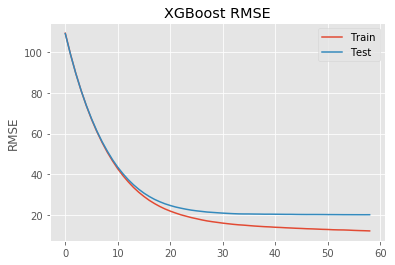

In [526]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgbr.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)
# make predictions for test data
y_pred = xgbr.predict(X_test)

# evaluate predictions
mse = mean_squared_error(y_test, y_pred)
print("RMSE: %.2f" % (np.sqrt(mse)))
# retrieve performance metrics
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

Write a function that goes through all the X tables and all the y. Baseline predictions parameters: learning_rate = 0.1,
                max_depth = 5, n_estimators = 60, others - default.

In [162]:
def predict(df_list, columns_list, X_end_loc, cv_n_splits, lr, n_estimators, max_depth, min_child_weight=1, colsample_bytree=1, 
                    alpha=0, reg_lambda=1):
    
    for i, df in enumerate(df_list):
        for column in columns_list:
            X,y = df.iloc[:,0:X_end_loc], pd.DataFrame(df[column])
            X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)
            xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = lr,
                    max_depth = max_depth, n_estimators = n_estimators, min_child_weight=min_child_weight, 
                    colsample_bytree=colsample_bytree, alpha=alpha, reg_lambda=reg_lambda) 

            xgbr.fit(X_train, y_train)

            kfold = KFold(n_splits=cv_n_splits, shuffle=True, random_state=11)
            kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
            print('Food table number {}, y = {}:'.format(i+1, column), "\nK-fold CV average score: %.2f" % ( kf_cv_scores.mean()))

            y_pred = xgbr.predict(X_test)
            print(r2_score(y_test, y_pred))
            

    return xgbr

### CV predictions

In [163]:
xgbr = predict([X1_night], ['CV'], X_end_loc=-4, cv_n_splits=3, lr=0.1, n_estimators=60, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = CV: 
K-fold CV average score: 0.13
0.18115914828646618


Best score reached 0.13

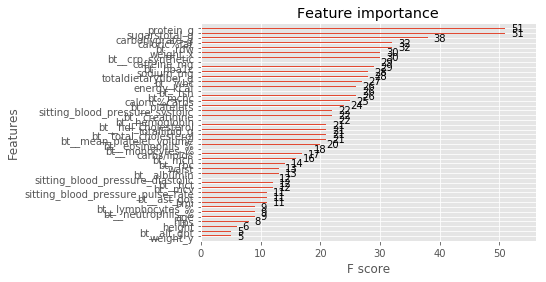

In [164]:
xgb.plot_importance(xgbr)
plt.rcParams['figure.figsize'] = [10, 20]

In [205]:
X,y = X2_night.iloc[:,0:-4], pd.DataFrame(X2_night['CV'])
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)

In [203]:
xgbr = predict([X2_night], ['CV'], X_end_loc=-4, cv_n_splits=3, lr=0.1, n_estimators=60, max_depth=5, min_child_weight=20, colsample_bytree=0.8, reg_lambda=18)

Food table number 1, y = CV: 
K-fold CV average score: 0.17
0.21192824973842217


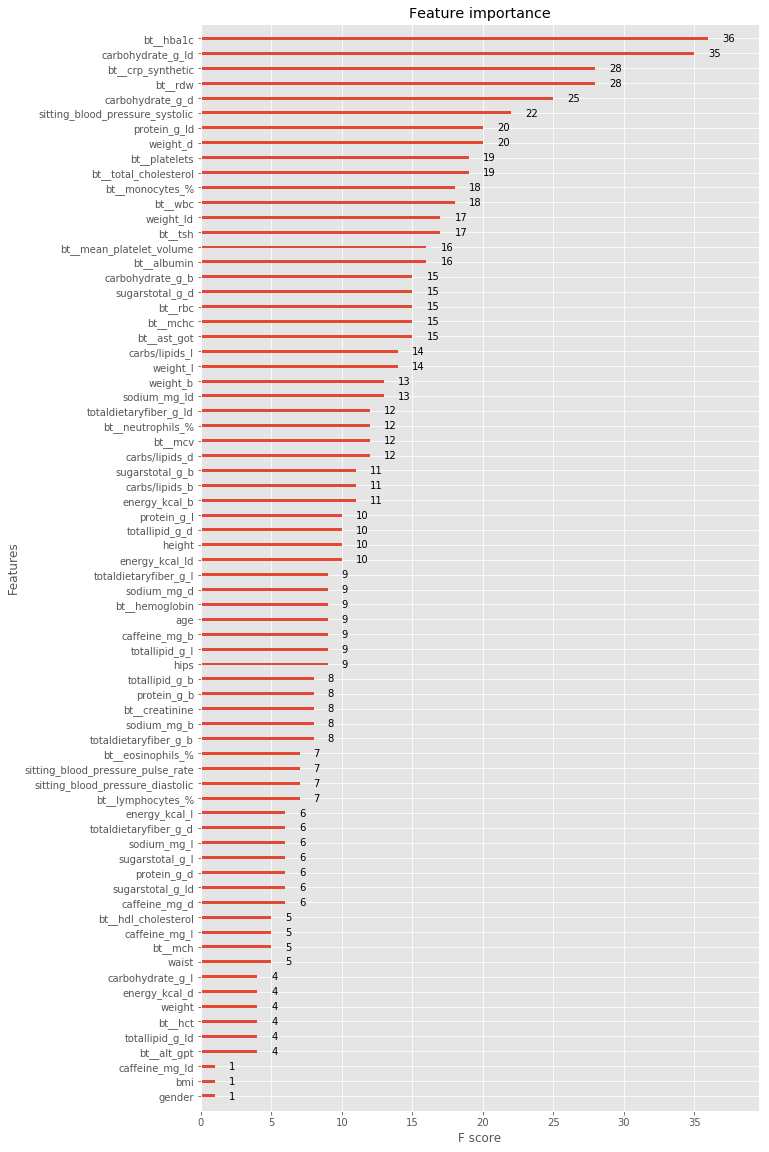

In [204]:
xgb.plot_importance(xgbr)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


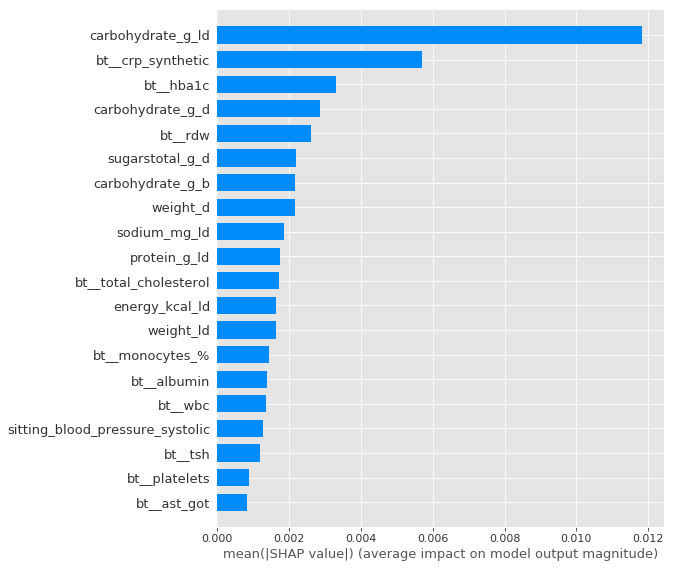

In [206]:
shap_values = shap.TreeExplainer(xgbr).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

shap.summary_plot(shap_values, X_train)

In [681]:
X3_night.iloc[:,264:]

bmi  sitting_blood_pressure_systolic  \
RegistrationCode Day                                                      
111527           2017-11-08  31.204312                            118.2   
                 2017-11-10  31.204312                            118.2   
                 2017-11-11  31.204312                            118.2   
                 2017-11-12  31.204312                            118.2   
                 2017-11-13  31.204312                            118.2   
...                                ...                              ...   
984879           2013-12-02  24.740938                            122.0   
                 2013-12-03  24.740938                            122.0   
                 2013-12-04  24.740938                            122.0   
                 2013-12-05  24.740938                            122.0   
                 2013-12-06  24.740938                            122.0   

                             sitting_blood_pressure_diastolic   hips  \
RegistrationCode Day                                                   
111527           2017-11-08                              88.6  111.0   
                 2017-11-10                              88.6  111.0   
                 2017-11-11                              88.6  111.0   
                 2017-11-12                              88.6  111.0   
                 2017-11-13                              88.6  111.0   
...                                                       ...    ...   
984879           2013-12-02                              86.0   96.0   
                 2013-12-03                              86.0   96.0   
                 2013-12-04                              86.0   96.0   
                 2013-12-05                              86.0   96.0   
                 2013-12-06                              86.0   96.0   

                             sitting_blood_pressure_pulse_rate  waist  \
RegistrationCode Day                                                    
111527           2017-11-08                               66.2   90.5   
                 2017-11-10                               66.2   90.5   
                 2017-11-11                               66.2   90.5   
                 2017-11-12                               66.2   90.5   
                 2017-11-13                               66.2   90.5   
...                                                        ...    ...   
984879           2013-12-02                               69.0   83.0   
                 2013-12-03                               69.0   83.0   
                 2013-12-04                               69.0   83.0   
                 2013-12-05                               69.0   83.0   
                 2013-12-06                               69.0   83.0   

                                 height  weight    bt__rdw  bt__hemoglobin  \
RegistrationCode Day                                                         
111527           2017-11-08  152.444444    72.5  14.033333       12.583333   
                 2017-11-10  152.444444    72.5  14.033333       12.583333   
                 2017-11-11  152.444444    72.5  14.033333       12.583333   
                 2017-11-12  152.444444    72.5  14.033333       12.583333   
                 2017-11-13  152.444444    72.5  14.033333       12.583333   
...                                 ...     ...        ...             ...   
984879           2013-12-02  167.000000    69.0  12.700000       14.500000   
                 2013-12-03  167.000000    69.0  12.700000       14.500000   
                 2013-12-04  167.000000    69.0  12.700000       14.500000   
                 2013-12-05  167.000000    69.0  12.700000       14.500000   
                 2013-12-06  167.000000    69.0  12.700000       14.500000   

                             ...  bt__albumin  bt__hba1c  bt__neutrophils_%  \
RegistrationCode Day         ...                                              

In [809]:
xgbr, y_test, y_pred = predict([X3_night.iloc[:,220:].drop(columns=[
       'sitting_blood_pressure_pulse_rate',
       'bt__lymphocytes_%', 'bt__monocytes_%',
       'bt__neutrophils_%', 'gender'
       ])], ['CV'], lr=0.1, n_estimators=80, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = CV: 
K-fold CV average score: 0.19
0.2559449258700425


In [812]:
plt.rcParams['figure.figsize'] = [7,7]

Text(0.5,1,'Prediction of the CV of the night from the diet')

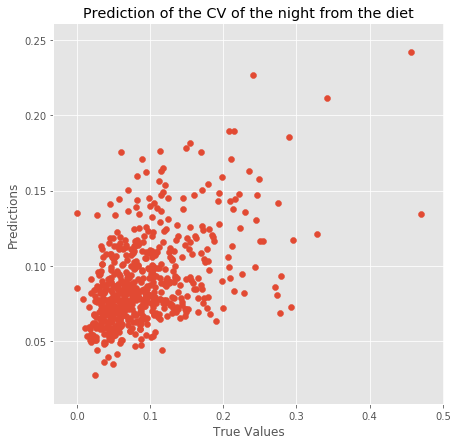

In [813]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction of the CV of the night from the diet')


### PPGR predictions

In [769]:
xgbr = predict([X1_night.iloc[:,12:]], ['PPGR'], lr=0.1, n_estimators=60, max_depth=4, min_child_weight=20)

Food table number 1, y = PPGR: 
K-fold CV average score: 0.07
0.11886285302937172


In [731]:
xgbr = predict([X2_night.drop(columns=['sodium_mg_b', 'sodium_mg_d', 'sodium_mg_l',
       'sodium_mg_ld', 'sugarstotal_g_b','sugarstotal_g_l',  'carbohydrate_g_b', 'carbohydrate_g_l',
        'energy_kcal_b', 'energy_kcal_l', 'protein_g_b', 'protein_g_l','carbs/lipids_b', 'carbs/lipids_l'
        ])], ['PPGR'], lr=0.1, n_estimators=60, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = PPGR: 
K-fold CV average score: 0.03
0.07796872016650147


In [770]:
xgbr = predict([X3_night.iloc[:,264:].drop(columns=[
       'sitting_blood_pressure_pulse_rate',
       'bt__lymphocytes_%', 'bt__monocytes_%',
       'bt__neutrophils_%', 'gender'
       ])], ['PPGR'], lr=0.08, n_estimators=80, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = PPGR: 
K-fold CV average score: 0.07
0.14209037521035595


### Min/max predictions

In [661]:
xgbr = predict([X1_night], ['min', 'max'], lr=0.1, n_estimators=60, max_depth=6, min_child_weight=20)

Food table number 1, y = min: 
K-fold CV average score: 0.42
0.4268327726494171
Food table number 1, y = max: 
K-fold CV average score: 0.36
0.29393150088941955


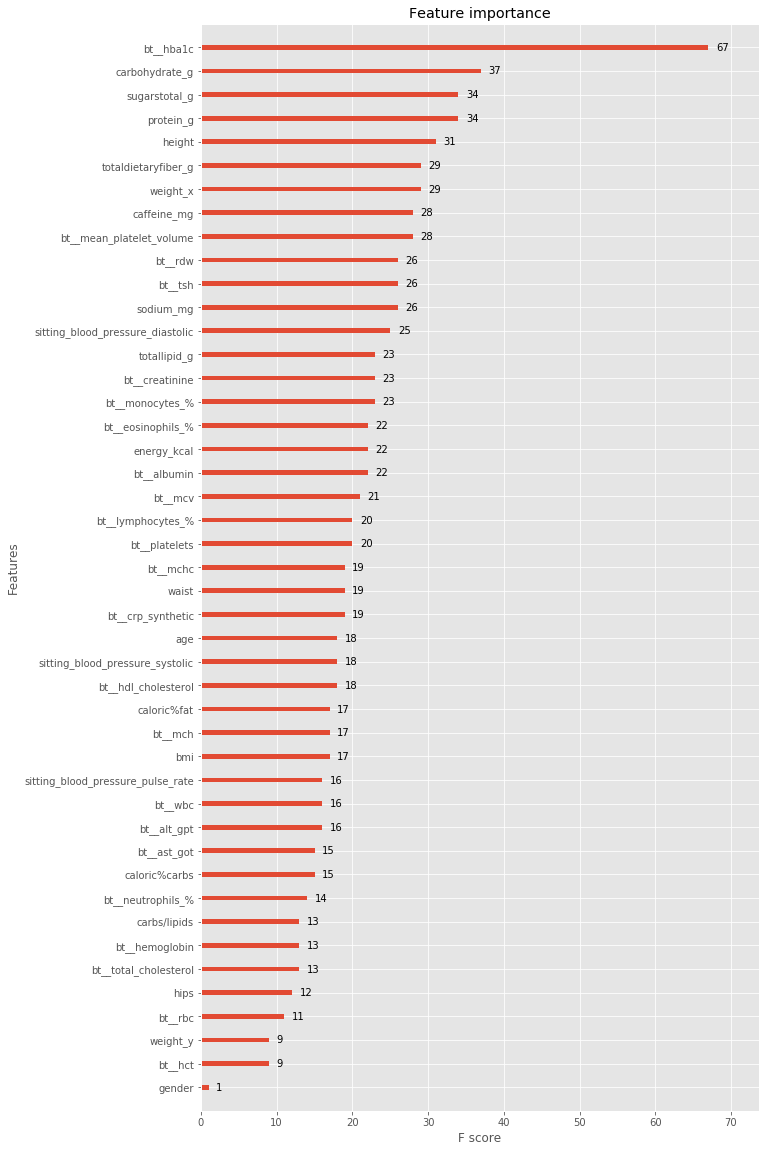

In [655]:
xgb.plot_importance(xgbr)

In [687]:
X2_night.iloc[:,39:].columns

Index(['bmi', 'sitting_blood_pressure_systolic',
       'sitting_blood_pressure_diastolic', 'hips',
       'sitting_blood_pressure_pulse_rate', 'waist', 'height', 'weight',
       'bt__rdw', 'bt__hemoglobin', 'bt__hdl_cholesterol', 'bt__lymphocytes_%',
       'bt__wbc', 'bt__mcv', 'bt__crp_synthetic', 'bt__mchc', 'bt__alt_gpt',
       'bt__tsh', 'bt__platelets', 'bt__creatinine', 'bt__hct',
       'bt__monocytes_%', 'bt__rbc', 'bt__eosinophils_%', 'bt__ast_got',
       'bt__total_cholesterol', 'bt__mch', 'bt__albumin', 'bt__hba1c',
       'bt__neutrophils_%', 'bt__mean_platelet_volume', 'age', 'gender', 'min',
       'max', 'CV', 'PPGR'],
      dtype='object')

In [689]:
xgbr = predict([X2_night.drop(columns=['sodium_mg_b', 'sodium_mg_d', 'sodium_mg_l',
       'sodium_mg_ld', 'sugarstotal_g_b','sugarstotal_g_l',  'carbohydrate_g_b', 'carbohydrate_g_l',
        'energy_kcal_b', 'energy_kcal_l', 'protein_g_b', 'protein_g_l','carbs/lipids_b', 'carbs/lipids_l'
        ])], ['min', 'max'], lr=0.1, n_estimators=60, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = min: 
K-fold CV average score: 0.46
0.4380561338801403
Food table number 1, y = max: 
K-fold CV average score: 0.37
0.30520553151988394


In [684]:
xgbr = predict([X3_night.iloc[:,264:].drop(columns=[
       'sitting_blood_pressure_pulse_rate',
       'bt__lymphocytes_%', 'bt__monocytes_%',
       'bt__neutrophils_%', 'gender'
       ])], ['min', 'max'], lr=0.1, n_estimators=80, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = min: 
K-fold CV average score: 0.46
0.43311683313640714
Food table number 1, y = max: 
K-fold CV average score: 0.37
0.30690243305201115


### WG predictions

In [692]:
X1_wg.columns

Index(['sugarstotal_g', 'sodium_mg', 'carbohydrate_g', 'energy_kcal',
       'protein_g', 'caffeine_mg', 'totaldietaryfiber_g', 'totallipid_g',
       'weight_x', 'carbs/lipids', 'caloric%carbs', 'caloric%fat', 'bmi',
       'sitting_blood_pressure_systolic', 'sitting_blood_pressure_diastolic',
       'hips', 'sitting_blood_pressure_pulse_rate', 'waist', 'height',
       'weight_y', 'bt__rdw', 'bt__hemoglobin', 'bt__hdl_cholesterol',
       'bt__lymphocytes_%', 'bt__wbc', 'bt__mcv', 'bt__crp_synthetic',
       'bt__mchc', 'bt__alt_gpt', 'bt__tsh', 'bt__platelets', 'bt__creatinine',
       'bt__hct', 'bt__monocytes_%', 'bt__rbc', 'bt__eosinophils_%',
       'bt__ast_got', 'bt__total_cholesterol', 'bt__mch', 'bt__albumin',
       'bt__hba1c', 'bt__neutrophils_%', 'bt__mean_platelet_volume', 'age',
       'gender', 'wakeup_glucose'],
      dtype='object')

In [798]:
xgbr = predict([X1_wg[['bmi',
       'sitting_blood_pressure_systolic', 'sitting_blood_pressure_diastolic',
       'hips', 'sitting_blood_pressure_pulse_rate', 'waist', 'height',
       'weight_y', 'bt__rdw', 'bt__hemoglobin', 'bt__hdl_cholesterol',
       'bt__lymphocytes_%', 'bt__wbc', 'bt__mcv', 'bt__crp_synthetic',
       'bt__mchc', 'bt__alt_gpt', 'bt__tsh', 'bt__platelets', 'bt__creatinine',
       'bt__hct', 'bt__monocytes_%', 'bt__rbc', 'bt__eosinophils_%',
       'bt__ast_got', 'bt__total_cholesterol', 'bt__mch', 'bt__albumin',
       'bt__hba1c', 'bt__neutrophils_%', 'bt__mean_platelet_volume', 'age',
       'gender', 'wakeup_glucose']]], ['wakeup_glucose'], lr=0.1, n_estimators=60, max_depth=5, min_child_weight=20)

Food table number 1, y = wakeup_glucose: 
K-fold CV average score: 0.53
0.5494210669503738


In [781]:
X1_cv_wg = pd.merge(X1_night[['min', 'max','CV','PPGR']], X1_wg, on=['RegistrationCode', 'Day'])

In [802]:
xgbr = predict([X1_cv_wg[['PPGR','bmi',
       'sitting_blood_pressure_systolic', 'sitting_blood_pressure_diastolic',
       'hips', 'sitting_blood_pressure_pulse_rate', 'waist', 'height',
       'weight_y', 'bt__rdw', 'bt__hemoglobin', 'bt__hdl_cholesterol',
       'bt__lymphocytes_%', 'bt__wbc', 'bt__mcv', 'bt__crp_synthetic',
       'bt__mchc', 'bt__alt_gpt', 'bt__tsh', 'bt__platelets', 'bt__creatinine',
       'bt__hct', 'bt__monocytes_%', 'bt__rbc', 'bt__eosinophils_%',
       'bt__ast_got', 'bt__total_cholesterol', 'bt__mch', 'bt__albumin',
       'bt__hba1c', 'bt__neutrophils_%', 'bt__mean_platelet_volume', 'age',
       'gender', 'wakeup_glucose']]], ['wakeup_glucose'], lr=0.1, n_estimators=100, max_depth=5, min_child_weight=20, 
        colsample_bytree=1)

Food table number 1, y = wakeup_glucose: 
K-fold CV average score: 0.57
0.6183419449803099


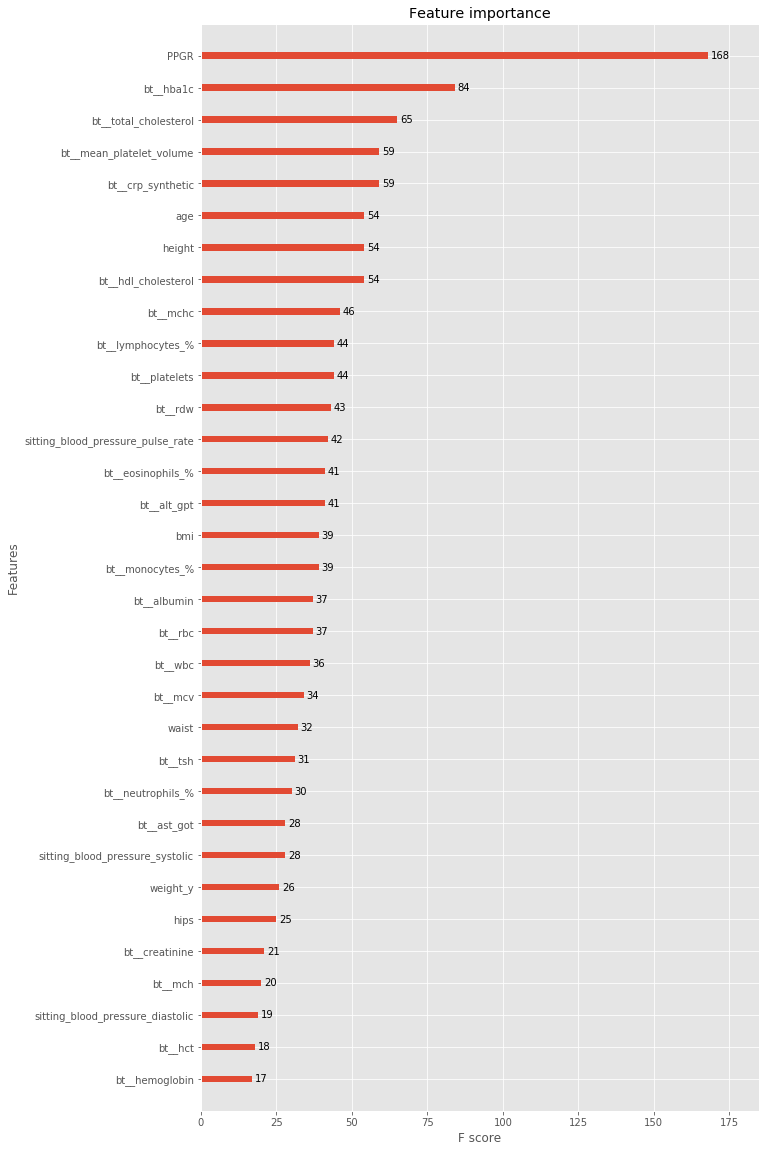

In [803]:
xgb.plot_importance(xgbr)

In [695]:
X2_wg.columns

Index(['sugarstotal_g_b', 'sugarstotal_g_d', 'sugarstotal_g_l',
       'sugarstotal_g_ld', 'sodium_mg_b', 'sodium_mg_d', 'sodium_mg_l',
       'sodium_mg_ld', 'carbohydrate_g_b', 'carbohydrate_g_d',
       'carbohydrate_g_l', 'carbohydrate_g_ld', 'energy_kcal_b',
       'energy_kcal_d', 'energy_kcal_l', 'energy_kcal_ld', 'protein_g_b',
       'protein_g_d', 'protein_g_l', 'protein_g_ld', 'caffeine_mg_b',
       'caffeine_mg_d', 'caffeine_mg_l', 'caffeine_mg_ld',
       'totaldietaryfiber_g_b', 'totaldietaryfiber_g_d',
       'totaldietaryfiber_g_l', 'totaldietaryfiber_g_ld', 'totallipid_g_b',
       'totallipid_g_d', 'totallipid_g_l', 'totallipid_g_ld', 'weight_b',
       'weight_d', 'weight_l', 'weight_ld', 'carbs/lipids_b', 'carbs/lipids_d',
       'carbs/lipids_l', 'bmi', 'sitting_blood_pressure_systolic',
       'sitting_blood_pressure_diastolic', 'hips',
       'sitting_blood_pressure_pulse_rate', 'waist', 'height', 'weight',
       'bt__rdw', 'bt__hemoglobin', 'bt__hdl_cholestero

In [697]:
xgbr = predict([X2_wg.drop(columns=['sodium_mg_b', 'sodium_mg_l',  'carbohydrate_g_b', 'carbohydrate_g_l',
        'energy_kcal_b', 'energy_kcal_l', 'protein_g_b', 'protein_g_l','carbs/lipids_b', 'carbs/lipids_l'
        ])], ['wakeup_glucose'], lr=0.1, n_estimators=60, max_depth=5, min_child_weight=20, colsample_bytree=0.8)

Food table number 1, y = wakeup_glucose: 
K-fold CV average score: 0.48
0.4854897865590223


In [514]:
X,y = X2_wg.iloc[:,0:-1], pd.DataFrame(X2_wg.iloc[:,-1])

In [515]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 100) 

xgbr.fit(X_train, y_train)

kfold = KFold(n_splits=3, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % ( kf_cv_scores.mean()))

y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

K-fold CV average score: 0.46


0.4998264316061545

## Data transformation

In [456]:
count

,Day
RegistrationCode,
10260,2
105043,5
111527,9
113719,5
115217,4
...,...
984879,4
988899,4
992638,12


Ok, I have approximately 2000 days with estimated wg values and food log for the previous day. I could now look by eye and per person on the days with specifically high wg and low and look at the food on the day befor, whether it was more than usual of something or less, earlier dinners or later dinners. 

In [60]:
def z_transform(df, column_to_transform):
    
    """Z score for the group (based on RC) from each value"""
    
    df_means = df.reset_index().groupby('RegistrationCode').mean()
    df_std =  df.reset_index().groupby('RegistrationCode').std()

    df = df.reset_index('Day')

    for rc in df_means.index.unique():
        df.loc[rc][column_to_transform] = df.loc[rc][column_to_transform].apply(lambda x: (x - df_means.loc[rc])/df_std.loc[rc])
        
    return df

In [144]:
wg_df_z = z_transform(wg_df, 'wakeup_glucose')

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Study the data

In [805]:
X1_night.sample(10)

,,sugarstotal_g,sodium_mg,carbohydrate_g,energy_kcal,protein_g,caffeine_mg,totaldietaryfiber_g,totallipid_g,weight_x,carbs/lipids,...,bt__albumin,bt__hba1c,bt__neutrophils_%,bt__mean_platelet_volume,age,gender,min,max,CV,PPGR
RegistrationCode,Day,,,,,,,,,,,,,,,,,,,,,
445179,2017-06-17,15.065810,4674.376354,76.205742,1826.235870,135.958493,0.00,8.093116,107.233947,1299.000000,0.710649,...,5.000000,5.635714,56.450000,9.116667,54.0,0.0,100.0,116.0,0.040013,3.912500
132095,2018-05-06,27.738704,6148.465958,265.054311,2586.396497,105.966375,142.50,21.379584,125.310226,2163.879999,2.115185,...,4.533333,5.951667,69.150000,9.900000,49.0,0.0,49.0,116.0,0.189298,1.788462
185604,2014-12-03,24.095400,3078.864740,137.982770,2032.332920,121.905872,213.35,25.626712,110.050672,2466.000000,1.253811,...,4.600000,5.890000,62.500000,8.400000,51.0,0.0,108.0,128.0,0.043405,4.140046
831208,2018-10-13,12.839800,3617.774600,187.463605,2128.314210,142.478988,225.00,30.881035,92.005907,2398.000000,2.037517,...,4.875000,5.885000,48.000000,9.700000,64.0,1.0,97.0,107.0,0.028296,2.187500
394693,2018-10-22,48.393163,3063.312320,139.365899,1780.201400,133.674555,171.50,16.420172,70.949350,3524.000000,1.964301,...,4.666667,5.885000,53.900000,9.550000,61.0,1.0,66.0,80.0,0.045120,5.833333
456910,2018-09-01,19.609300,7630.717861,329.074965,2803.707710,131.646096,28.80,22.035902,98.824060,3936.900000,3.329907,...,4.966667,5.738333,65.066667,8.216667,63.0,1.0,86.0,119.0,0.102726,0.236111
859286,2018-08-27,77.404500,7090.735000,226.497800,2103.060000,107.591450,113.43,66.972340,72.462150,2535.000000,3.125739,...,5.000000,5.846667,61.133333,8.116667,60.0,1.0,78.0,126.0,0.136621,7.100000
632605,2014-12-16,35.130500,1624.458903,216.449273,1746.298987,90.311080,220.50,36.595978,50.119380,5147.000000,4.318674,...,4.300000,5.700000,53.700000,10.900000,67.0,0.0,111.0,137.0,0.058891,2.507523
495288,2017-09-29,20.505200,2175.258760,170.780770,1424.432120,52.999475,115.20,12.012470,58.346388,1242.000000,2.927015,...,4.766667,6.122143,52.216667,9.700000,46.0,0.0,112.0,182.0,0.170765,2.364583


In [806]:
night_stats.sample(10)

,,min,max,CV,PPGR
RegistrationCode,Day,,,,
745073,2018-05-06,78.0,123.0,0.150902,3.547619
607468,2014-05-17,108.0,172.0,0.123011,16.401042
697184,2014-07-26,90.0,108.0,0.041201,5.247685
132178,2018-02-06,100.0,127.0,0.068781,8.630000
494090,2017-08-17,87.0,130.0,0.089121,8.039062
723796,2018-03-18,90.0,126.0,0.103528,0.903409
122175,2014-11-23,108.0,140.0,0.097345,3.038095
304470,2014-08-18,132.0,156.0,0.055742,0.442130
347434,2018-10-16,73.0,140.0,0.202545,5.732955


In [85]:
log = dll.get_data(study_ids=3).df
log = log.reset_index()
log['Day'] = log['Date'].dt.date
log = log.set_index(['RegistrationCode', 'Day'])
log = log.loc[prof_index].reset_index().drop(columns='Day').set_index(['RegistrationCode', 'Date', 'food_id'])

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


In [86]:
logdf = dll.add_nutrients(log, nutrient_list)
logdf = dll.squeeze_log(logdf)
logdf = logdf.reset_index()
logdf['Day'] = logdf['Date'].dt.date

In [94]:
def vis_cgm(rc, date):
    
    cgm_slice = profling_cgm[(profling_cgm['RegistrationCode'] == rc) & (profling_cgm['Day'] == date)]
    return px.line(cgm_slice.reset_index(), x="Date", y="GlucoseValue", title='day CGM')

In [148]:
vis_cgm('111527', datetime.date(2017,11,14))

In [100]:
logdf = logdf.set_index(['RegistrationCode', 'Day'])

In [147]:
logdf.loc[('111527', '2017-11-14')]

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



Date  sugarstotal_g  sodium_mg  \
RegistrationCode Day                                                        
111527           2017-11-14 2017-11-14 07:07:01         4.2300      4.800   
                 2017-11-14 2017-11-14 10:00:53         1.2170    396.540   
                 2017-11-14 2017-11-14 18:45:34         0.7364    388.279   

                             carbohydrate_g  score  energy_kcal  protein_g  \
RegistrationCode Day                                                         
111527           2017-11-14         12.0060    0.0       71.880    1.38600   
                 2017-11-14         32.2870    0.0      237.780   18.21530   
                 2017-11-14         23.3277    0.0      258.595    9.79103   

                             caffeine_mg  totaldietaryfiber_g  totallipid_g  \
RegistrationCode Day                                                          
111527           2017-11-14        108.0              0.99000       1.65000   
                 2017-11-14        216.0              2.90000       4.43010   
                 2017-11-14          0.0              2.95748      12.88667   

                             weight meal_type  
RegistrationCode Day                           
111527           2017-11-14  258.01     Snack  
                 2017-11-14  621.02      Meal  
                 2017-11-14  404.00      Meal

In [153]:
wg_df.sample(10)

,,wakeup_glucose
RegistrationCode,Day,
69618,2017-05-08,93.000000
376789,2017-04-29,92.750000
831208,2018-10-23,95.000000
64952,2018-04-23,93.000000
818980,2019-02-06,102.250000
805227,2018-09-01,82.000000
246043,2018-11-25,89.500000
492806,2017-05-03,101.500000
867514,2018-10-23,82.333333


In [159]:
wg_df.loc[('492806', slice(None))]

,wakeup_glucose
Day,
2017-04-28,96.00
2017-04-30,101.00
2017-05-01,93.75
2017-05-02,92.00
2017-05-03,101.50
2017-05-04,105.00
2017-05-05,97.00
2017-05-06,81.00
2017-05-07,101.00


In [170]:
vis_cgm('492806', datetime.date(2017,5,4))

In [171]:
logdf.loc[('492806', '2017-05-01')]

/home/elming/anaconda3/envs/mylabdata/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning:

indexing past lexsort depth may impact performance.



Date  sugarstotal_g   sodium_mg  \
RegistrationCode Day                                                         
492806           2017-05-01 2017-05-01 07:13:55       0.682275   812.27500   
                 2017-05-01 2017-05-01 10:30:15       5.340000    42.00000   
                 2017-05-01 2017-05-01 13:00:09       1.960000  3146.71752   
                 2017-05-01 2017-05-01 18:30:29       0.000000   923.74650   
                 2017-05-01 2017-05-01 23:02:32       0.384000   920.61160   

                             carbohydrate_g  score  energy_kcal  protein_g  \
RegistrationCode Day                                                         
492806           2017-05-01       41.726250    0.0   303.900000  17.607000   
                 2017-05-01        4.640000    0.0    62.000000   3.400000   
                 2017-05-01       46.934294    0.0   675.733016  39.404682   
                 2017-05-01       31.718324    0.0   507.800340   6.674913   
                 2017-05-01       15.041168    0.0   431.798620   4.390252   

                             caffeine_mg  totaldietaryfiber_g  totallipid_g  \
RegistrationCode Day                                                          
492806           2017-05-01        108.0             1.733820      7.423000   
                 2017-05-01         48.0             0.200000      3.320000   
                 2017-05-01          0.0            25.508253     30.504348   
                 2017-05-01         42.6             6.505838     37.592490   
                 2017-05-01        108.0             1.994230     39.312998   

                             weight meal_type  
RegistrationCode Day                           
492806           2017-05-01  421.01      Meal  
                 2017-05-01  200.00  Beverage  
                 2017-05-01  852.00      Meal  
                 2017-05-01  281.01      Meal  
                 2017-05-01  508.01      Meal

## Predict wg from the diet

In [150]:
data_df = pd.merge(hourly_log, wg_df_z, on = ['RegistrationCode', 'Day']).set_index('Day', append=True)
data_df.head()

(0, sugarstotal_g)  (0, sodium_mg)  \
RegistrationCode Day                                              
111527           2017-11-11                 0.0             0.0   
                 2017-11-12                 0.0             0.0   
                 2017-11-13                 0.0             0.0   
                 2017-11-14                 0.0             0.0   
                 2017-11-16                 0.0             0.0   

                             (0, carbohydrate_g)  (0, energy_kcal)  \
RegistrationCode Day                                                 
111527           2017-11-11                  0.0               0.0   
                 2017-11-12                  0.0               0.0   
                 2017-11-13                  0.0               0.0   
                 2017-11-14                  0.0               0.0   
                 2017-11-16                  0.0               0.0   

                             (0, protein_g)  (0, caffeine_mg)  \
RegistrationCode Day                                            
111527           2017-11-11             0.0               0.0   
                 2017-11-12             0.0               0.0   
                 2017-11-13             0.0               0.0   
                 2017-11-14             0.0               0.0   
                 2017-11-16             0.0               0.0   

                             (0, totaldietaryfiber_g)  (0, totallipid_g)  \
RegistrationCode Day                                                       
111527           2017-11-11                       0.0                0.0   
                 2017-11-12                       0.0                0.0   
                 2017-11-13                       0.0                0.0   
                 2017-11-14                       0.0                0.0   
                 2017-11-16                       0.0                0.0   

                             (0, weight)  (0, caloric%carbs)  ...  \
RegistrationCode Day                                          ...   
111527           2017-11-11          0.0                 0.0  ...   
                 2017-11-12          0.0                 0.0  ...   
                 2017-11-13          0.0                 0.0  ...   
                 2017-11-14          0.0                 0.0  ...   
                 2017-11-16          0.0                 0.0  ...   

                             (23, carbohydrate_g)  (23, energy_kcal)  \
RegistrationCode Day                                                   
111527           2017-11-11                   0.0                0.0   
                 2017-11-12                   0.0                0.0   
                 2017-11-13                   0.0                0.0   
                 2017-11-14                   0.0                0.0   
                 2017-11-16                   0.0                0.0   

                             (23, protein_g)  (23, caffeine_mg)  \
RegistrationCode Day                                              
111527           2017-11-11              0.0                0.0   
                 2017-11-12              0.0                0.0   
                 2017-11-13              0.0                0.0   
                 2017-11-14              0.0                0.0   
                 2017-11-16              0.0                0.0   

                             (23, totaldietaryfiber_g)  (23, totallipid_g)  \
RegistrationCode Day                                                         
111527           2017-11-11                        0.0                 0.0   
                 2017-11-12                        0.0                 0.0   
                 2017-11-13                        0.0                 0.0   
                 2017-11-14                        0.0                 0.0   
                 2017-11-16                        0.0                 0.0   

                             (23, weight)  (23, caloric%carbs)  \
Registr

1632 rows left in total only, bcs many days get filtered out having less than 1000 kcal per day.

In [152]:
X,y = data_df.iloc[:,0:-1], pd.DataFrame(data_df.iloc[:,-1])
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=383)

xgbr = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, n_estimators = 100) 

xgbr.fit(X_train, y_train)

kfold = KFold(n_splits=3, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % ( kf_cv_scores.mean()))

y_pred = xgbr.predict(X_test)
r2_score(y_test, y_pred)

K-fold CV average score: -0.09


-0.055193711132924594

Why could the prediction not work?
- I think mostly because of the wrong way of looking at the wake up glucose.
    - 5-6 am is lower than 6-7. For example a person experiences rise in blood glucose around 6 am. On a particular day this person ate earlier than usual (6:40), so I will shift my estimation to 5-6 and it will capture too low values even though wg just before breakfast was around his usual levels. 
    - if I do the estimation just before the breakfast, then it is also biased. Maybe on some day a person just didn't have any food for several hours after wake up, so his glucose went down a lot before the first meal. The diet in the day before will not explain this extremely low value.